# Clinical Screening: Features That Differentiate Clusters

Comprehensive statistical screening of all features to find which best differentiate the 3 clusters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, kruskal

df = pd.read_csv("../data/processed/02_clustered_data.csv")
print(f"Shape: {df.shape}")
print("\nCluster distribution:")
print(df["Cluster"].value_counts().sort_index())

Shape: (603, 52)

Cluster distribution:
Cluster
0    359
1    104
2    140
Name: count, dtype: int64


In [2]:
exclude_cols = {"Patient ID", "Cluster"}
results = []

for col in df.columns:
    if col in exclude_cols:
        continue
    if not np.issubdtype(df[col].dtype, np.number):
        continue
    
    # Drop NaNs for this column
    valid = df[[col, "Cluster"]].dropna()
    if len(valid) < 10:
        continue
    
    uniq = set(valid[col].dropna().unique())
    is_binary = uniq.issubset({0, 1}) or uniq.issubset({0.0, 1.0})
    
    means = valid.groupby("Cluster")[col].mean()
    m0 = means.get(0, np.nan)
    m1 = means.get(1, np.nan)
    m2 = means.get(2, np.nan)
    
    if is_binary:
        table = pd.crosstab(valid[col], valid["Cluster"])
        if table.size < 2 or table.shape[0] < 2:
            continue
        try:
            chi2, p, dof, expected = chi2_contingency(table)
            results.append([col, "Chi-Square", p, m0, m1, m2])
        except Exception:
            continue
    else:
        g0 = valid.loc[valid["Cluster"] == 0, col].values
        g1 = valid.loc[valid["Cluster"] == 1, col].values
        g2 = valid.loc[valid["Cluster"] == 2, col].values
        if len(g0) < 2 or len(g1) < 2 or len(g2) < 2:
            continue
        try:
            stat, p = kruskal(g0, g1, g2)
            results.append([col, "Kruskal-Wallis", p, m0, m1, m2])
        except Exception:
            continue

results_df = pd.DataFrame(results, columns=["Feature", "Test", "P_Value", "Mean_C0", "Mean_C1", "Mean_C2"])
results_df = results_df.sort_values("P_Value", ascending=True).reset_index(drop=True)
results_df

,Feature,Test,P_Value,Mean_C0,Mean_C1,Mean_C2
0,Metamyelocytes,Kruskal-Wallis,5.666239e-130,-5.199338,1.500354,-5.199338
1,Myelocytes,Kruskal-Wallis,1.257876e-47,-5.199338,-2.303763,-5.199338
2,Rods #,Kruskal-Wallis,4.916240e-45,-0.329693,1.079400,-3.343216
3,Basophils,Kruskal-Wallis,1.070848e-38,0.326444,-0.460402,-3.146606
4,Hematocrit,Kruskal-Wallis,5.715713e-21,0.322182,-0.428670,-0.510103
5,Hemoglobin,Kruskal-Wallis,6.458434e-21,0.323786,-0.461979,-0.489539
6,HCO3 (venous blood gas analysis),Kruskal-Wallis,1.433194e-17,0.256742,0.050241,-0.695776
7,Total CO2 (venous blood gas analysis),Kruskal-Wallis,2.112380e-17,0.256115,0.048614,-0.692947
8,Monocytes,Kruskal-Wallis,5.662714e-16,0.024079,0.631904,-0.531975
9,Base excess (venous blood gas analysis),Kruskal-Wallis,7.790532e-16,0.222175,0.125915,-0.663184


In [3]:
print("Top 20 by P-Value:")
display(results_df.head(20))
results_df.to_csv("significance_ranking.csv", index=False)
print("\nSaved: significance_ranking.csv")

Top 20 by P-Value:


,Feature,Test,P_Value,Mean_C0,Mean_C1,Mean_C2
0,Metamyelocytes,Kruskal-Wallis,5.666239e-130,-5.199338,1.500354,-5.199338
1,Myelocytes,Kruskal-Wallis,1.257876e-47,-5.199338,-2.303763,-5.199338
2,Rods #,Kruskal-Wallis,4.916240e-45,-0.329693,1.079400,-3.343216
3,Basophils,Kruskal-Wallis,1.070848e-38,0.326444,-0.460402,-3.146606
4,Hematocrit,Kruskal-Wallis,5.715713e-21,0.322182,-0.428670,-0.510103
5,Hemoglobin,Kruskal-Wallis,6.458434e-21,0.323786,-0.461979,-0.489539
6,HCO3 (venous blood gas analysis),Kruskal-Wallis,1.433194e-17,0.256742,0.050241,-0.695776
7,Total CO2 (venous blood gas analysis),Kruskal-Wallis,2.112380e-17,0.256115,0.048614,-0.692947
8,Monocytes,Kruskal-Wallis,5.662714e-16,0.024079,0.631904,-0.531975
9,Base excess (venous blood gas analysis),Kruskal-Wallis,7.790532e-16,0.222175,0.125915,-0.663184



Saved: significance_ranking.csv


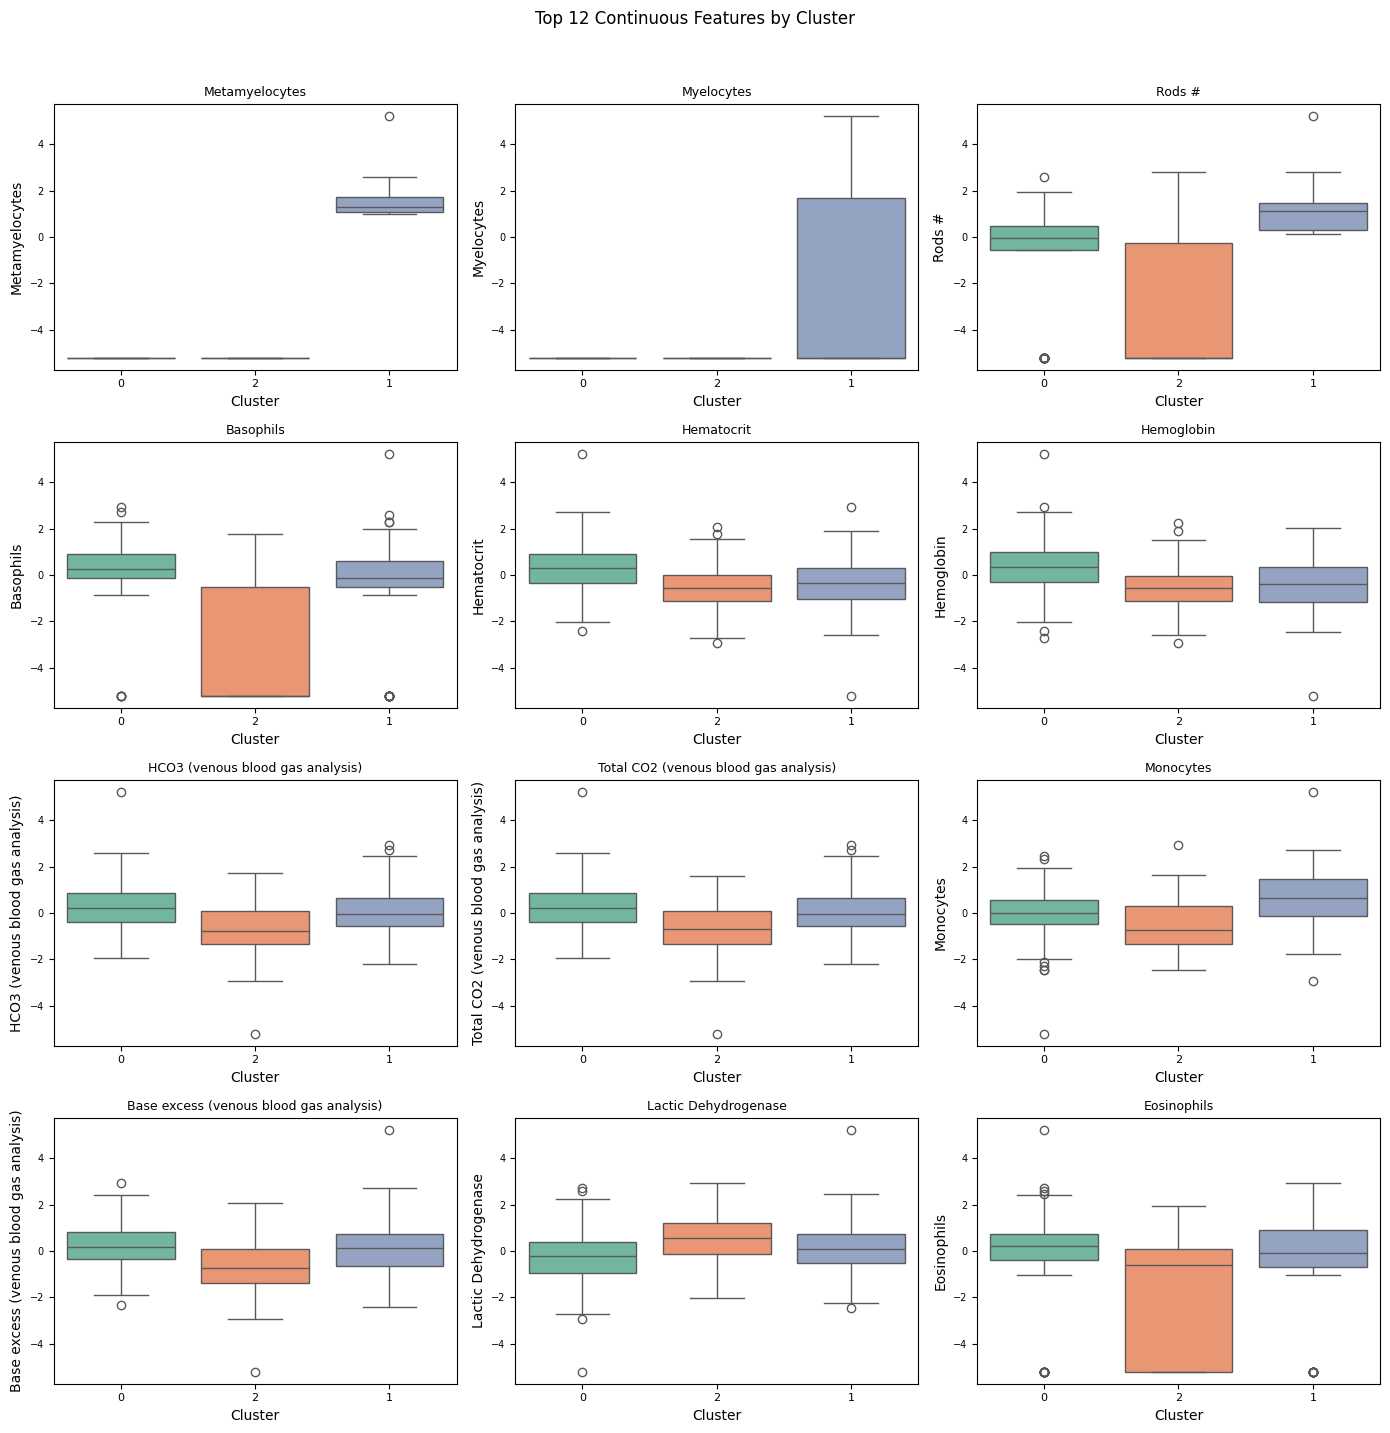

In [4]:
# Top 12 CONTINUOUS features (exclude Chi-Square / binary)
top_continuous = results_df[results_df["Test"] == "Kruskal-Wallis"].head(12)
features_top12 = top_continuous["Feature"].tolist()

fig, axes = plt.subplots(4, 3, figsize=(14, 14))
axes = axes.flatten()

for i, feat in enumerate(features_top12):
    ax = axes[i]
    df_plot = df[[feat, "Cluster"]].dropna()
    df_plot["Cluster"] = df_plot["Cluster"].astype(str)
    sns.boxplot(data=df_plot, x="Cluster", y=feat, hue="Cluster", palette="Set2", legend=False, ax=ax)
    ax.set_title(feat, fontsize=9)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=7)

plt.suptitle("Top 12 Continuous Features by Cluster", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("boxplots_top12_significant.png", dpi=150, bbox_inches="tight")
plt.show()

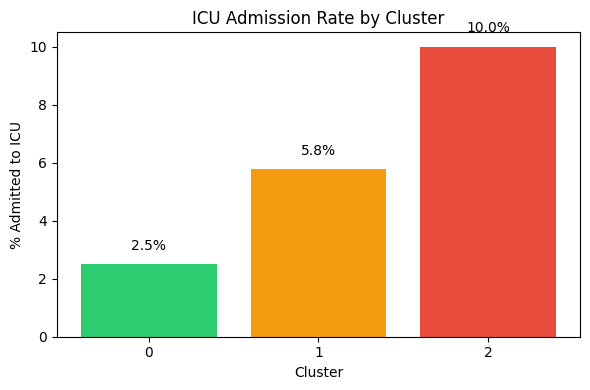

In [5]:
# ICU admission by cluster
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
if icu_col in df.columns:
    rates = df.groupby("Cluster")[icu_col].mean() * 100
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(rates.index.astype(str), rates.values, color=["#2ecc71", "#f39c12", "#e74c3c"])
    ax.set_xlabel("Cluster")
    ax.set_ylabel("% Admitted to ICU")
    ax.set_title("ICU Admission Rate by Cluster")
    for b, v in zip(bars, rates.values):
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5, f"{v:.1f}%", ha="center", fontsize=10)
    plt.tight_layout()
    plt.savefig("icu_rate_by_cluster.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print(f"Column '{icu_col}' not found.")